In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import env
from wrangle import *

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Acquire data

df = acquire_zillow()

In [3]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,latitude,longitude,lotsizesquarefeet,garagecarcnt
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,Condominium,2017-08-04,33922098.0,-117954970.0,NaN,1.0
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,34033180.0,-118355396.0,5672.0,NaN
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23,34686163.0,-118113100.0,8284.0,NaN
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,Condominium,2017-07-28,34073222.0,-118390965.0,25082.0,NaN
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,33999877.0,-118291863.0,6707.0,NaN


In [4]:
# Remove Outliers

col_list = ['bedrooms','bathrooms','area','tax_value','taxamount']
df = remove_outliers(df,1.5,col_list)

In [5]:
# Drop taxamount, tax_value is our target
df.drop(columns = 'taxamount', inplace = True)

In [6]:
# Imputing year_built with most_frequent value

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df[['year_built']])
df[['year_built']] = imputer.transform(df[['year_built']])

In [7]:
# Imputing lotsize with mean

imputer = SimpleImputer(strategy='mean')
imputer.fit(df[['lotsizesquarefeet']])
df[['lotsizesquarefeet']] = imputer.transform(df[['lotsizesquarefeet']])

In [8]:
# Fill garagecarcnt

df['garagecarcnt'] = df['garagecarcnt'].fillna(0)


In [9]:
# Checking for nulls

df.isnull().any()

bedrooms               False
bathrooms              False
area                   False
tax_value              False
year_built             False
fips                   False
propertylandusedesc    False
transactiondate        False
latitude               False
longitude              False
lotsizesquarefeet      False
garagecarcnt           False
dtype: bool

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33822 entries, 0 to 38581
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bedrooms             33822 non-null  float64
 1   bathrooms            33822 non-null  float64
 2   area                 33822 non-null  float64
 3   tax_value            33822 non-null  float64
 4   year_built           33822 non-null  float64
 5   fips                 33822 non-null  float64
 6   propertylandusedesc  33822 non-null  object 
 7   transactiondate      33822 non-null  object 
 8   latitude             33822 non-null  float64
 9   longitude            33822 non-null  float64
 10  lotsizesquarefeet    33822 non-null  float64
 11  garagecarcnt         33822 non-null  float64
dtypes: float64(10), object(2)
memory usage: 3.4+ MB


In [11]:
df.propertylandusedesc.value_counts()

Single Family Residential    23823
Condominium                   9784
Cluster Home                   184
Mobile Home                     27
Townhouse                        3
Residential General              1
Name: propertylandusedesc, dtype: int64

In [12]:
# Dropping low count propertylandusedec

df = df[df.propertylandusedesc != 'Residential General']
df = df[df.propertylandusedesc != 'Townhouse']


# Dropping propertylandusedesc

df.drop(columns = 'propertylandusedesc', inplace=True)



In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33818 entries, 0 to 38581
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           33818 non-null  float64
 1   bathrooms          33818 non-null  float64
 2   area               33818 non-null  float64
 3   tax_value          33818 non-null  float64
 4   year_built         33818 non-null  float64
 5   fips               33818 non-null  float64
 6   transactiondate    33818 non-null  object 
 7   latitude           33818 non-null  float64
 8   longitude          33818 non-null  float64
 9   lotsizesquarefeet  33818 non-null  float64
 10  garagecarcnt       33818 non-null  float64
dtypes: float64(10), object(1)
memory usage: 3.1+ MB


In [14]:
# Converting transactiondate into datetime

df['transactiondate'] = pd.to_datetime(df['transactiondate'],\
                        format = '%Y-%m-%d', errors = 'coerce')

# Creating columns for month, day, and week. We know they're all 2017
# so we don't need year

df['transactiondate_month'] = df['transactiondate'].dt.month
df['transactiondate_day'] = df['transactiondate'].dt.day
df['transactiondate_week'] = df['transactiondate'].dt.week

# Dropping transactiondate

df.drop(columns='transactiondate', inplace=True)

df.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips,latitude,longitude,lotsizesquarefeet,garagecarcnt,transactiondate_month,transactiondate_day,transactiondate_week
0,3.0,2.0,1125.0,289445.0,1974.0,6059.0,33922098.0,-117954970.0,30617.039151,1.0,8,4,31
1,3.0,2.0,1316.0,205123.0,1923.0,6037.0,34033180.0,-118355396.0,5672.000000,0.0,7,21,29
2,3.0,2.0,1458.0,136104.0,1970.0,6037.0,34686163.0,-118113100.0,8284.000000,0.0,6,23,25
3,3.0,2.0,1766.0,810694.0,1980.0,6037.0,34073222.0,-118390965.0,25082.000000,0.0,7,28,30
4,2.0,1.0,1421.0,35606.0,1911.0,6037.0,33999877.0,-118291863.0,6707.000000,0.0,6,30,26


In [15]:
# Last check to see column data types

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33818 entries, 0 to 38581
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bedrooms               33818 non-null  float64
 1   bathrooms              33818 non-null  float64
 2   area                   33818 non-null  float64
 3   tax_value              33818 non-null  float64
 4   year_built             33818 non-null  float64
 5   fips                   33818 non-null  float64
 6   latitude               33818 non-null  float64
 7   longitude              33818 non-null  float64
 8   lotsizesquarefeet      33818 non-null  float64
 9   garagecarcnt           33818 non-null  float64
 10  transactiondate_month  33818 non-null  int64  
 11  transactiondate_day    33818 non-null  int64  
 12  transactiondate_week   33818 non-null  int64  
dtypes: float64(10), int64(3)
memory usage: 3.6 MB


In [16]:
#train/validate/test split
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [17]:
train.shape

(18937, 13)

In [18]:
train.head()

,bedrooms,bathrooms,area,tax_value,year_built,fips,latitude,longitude,lotsizesquarefeet,garagecarcnt,transactiondate_month,transactiondate_day,transactiondate_week
21642,2.0,2.0,1498.0,408085.0,1997.0,6059.0,33730036.0,-117754921.0,3462.0,2.0,7,7,27
34787,3.0,2.0,1529.0,159673.0,1989.0,6037.0,34567163.0,-118035507.0,6629.0,0.0,8,21,34
30931,3.0,2.0,1345.0,217094.0,1987.0,6037.0,34622769.0,-118216846.0,6840.0,0.0,8,8,32
29166,2.0,3.0,1815.0,201312.0,1974.0,6037.0,34161200.0,-118504000.0,59272.0,0.0,7,31,31
15746,4.0,2.5,2009.0,532600.0,1961.0,6059.0,33810923.0,-118035523.0,7605.0,2.0,6,20,25


In [19]:
validate.shape

(8117, 13)

In [20]:
test.shape

(6764, 13)

In [21]:
# drop target column
X_train = train.drop(columns = 'tax_value')
y_train = train.tax_value

X_validate = validate.drop(columns = 'tax_value')
y_validate = validate.tax_value

X_test = test.drop(columns = 'tax_value')
y_test = test.tax_value

In [22]:
# scaling my X data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [23]:
X_validate = pd.DataFrame(X_validate)
type(X_validate)

pandas.core.frame.DataFrame

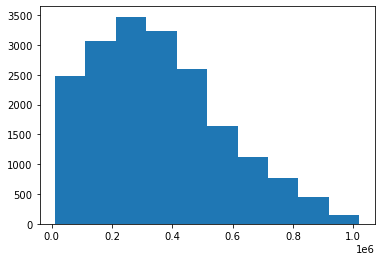

In [24]:
plt.hist(y_train)
plt.show()

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the tax_value without using any features. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


In [25]:
# We need y_train, y_validate and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  212710.78 
Validate/Out-of-Sample:  209806.82


In [26]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  214575.17 
Validate/Out-of-Sample:  211504.04


In [27]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [28]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.0


### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [29]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)

In [30]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [31]:
# predict train
# 
# use the thing!
# 
y_train['tax_value_pred_lm'] = lm.predict(X_train)

In [32]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** .5

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  183155.76126230237 
Validation/Out-of-Sample:  179934.14505728823


In [33]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.000000
1,OLS Regressor,179934.145057,0.264853


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [34]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  183162.05516654605 
Validation/Out-of-Sample:  179934.14505728823


In [35]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [36]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.000000
1,OLS Regressor,179934.145057,0.264853
2,lasso_alpha_1,179939.495937,0.264807


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict tax_value in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [37]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  183061.2918498527 
Validation/Out-of-Sample:  183061.2918498527


In [38]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_glm,
               'glm_poisson',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.000000
1,OLS Regressor,179934.145057,0.264853
2,lasso_alpha_1,179939.495937,0.264807
3,glm_poisson,179960.945397,0.264594


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [39]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

## **LinearRegression**

In [40]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  176946.26117311505 
Validation/Out-of-Sample:  175689.88383030304


In [41]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lm2,
               'quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.000000
1,OLS Regressor,179934.145057,0.264853
2,lasso_alpha_1,179939.495937,0.264807
3,glm_poisson,179960.945397,0.264594
4,quadratic,175689.883830,0.299055


### Evaluate

**Plotting Actual vs. Predicted Values**

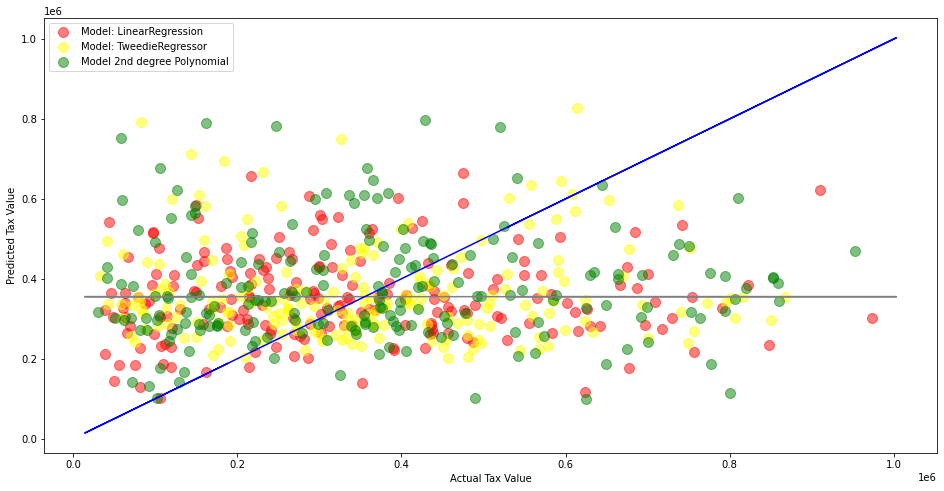

In [42]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=1, color="gray", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=1, color="blue", label='_nolegend_')

plt.scatter(y_validate.tax_value.sample(n=200), y_validate.tax_value_pred_lm.sample(n=200), 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value.sample(n=200), y_validate.tax_value_pred_glm.sample(n=200), 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value.sample(n=200), y_validate.tax_value_pred_lm2.sample(n=200), 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

#### Residual Plots: Plotting the Errors in Predictions

In [43]:
y_validate.tax_value.sample(n=100)

24703    345185.0
33532    420079.0
23235    160050.0
14285    650907.0
4949      89874.0
           ...   
6057     357144.0
33067    262000.0
36110    440100.0
27997    187000.0
26891    335088.0
Name: tax_value, Length: 100, dtype: float64

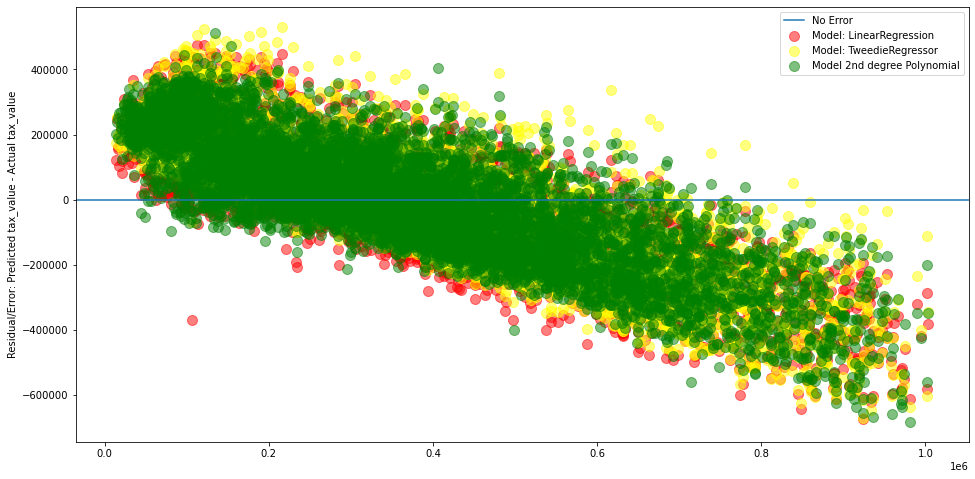

In [44]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value , 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.ylabel("Residual/Error: Predicted tax_value - Actual tax_value")
plt.show()

#### Histograms

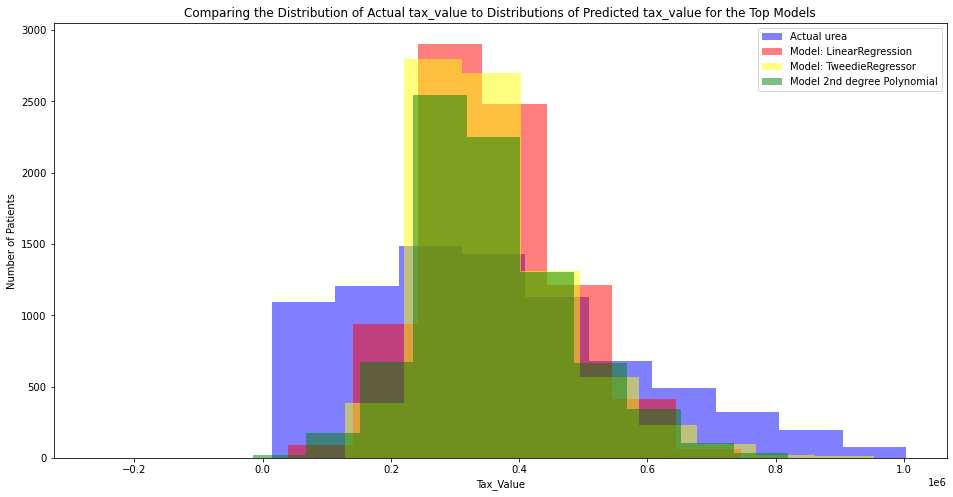

In [45]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual urea")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Tax_Value")
plt.ylabel("Number of Patients")
plt.title("Comparing the Distribution of Actual tax_value to Distributions of Predicted tax_value for the Top Models")
plt.legend()
plt.show()

In [46]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.000000
1,OLS Regressor,179934.145057,0.264853
2,lasso_alpha_1,179939.495937,0.264807
3,glm_poisson,179960.945397,0.264594
4,quadratic,175689.883830,0.299055


In [47]:
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
#lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

# predict test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train,
      "\nValidate/Out-of-Sample: ", rmse_validate,
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  176946.26117311505 
Validate/Out-of-Sample:  175689.88383030304 
Test/Out-of-Sample:  176004.5157045914


In [48]:
metric_df = make_metric_df(y_test.tax_value,
               y_test.tax_value_pred_lm2,
               'test_quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,212710.783597,0.000000
1,OLS Regressor,179934.145057,0.264853
2,lasso_alpha_1,179939.495937,0.264807
3,glm_poisson,179960.945397,0.264594
4,quadratic,175689.883830,0.299055
5,test_quadratic,176004.515705,0.298274


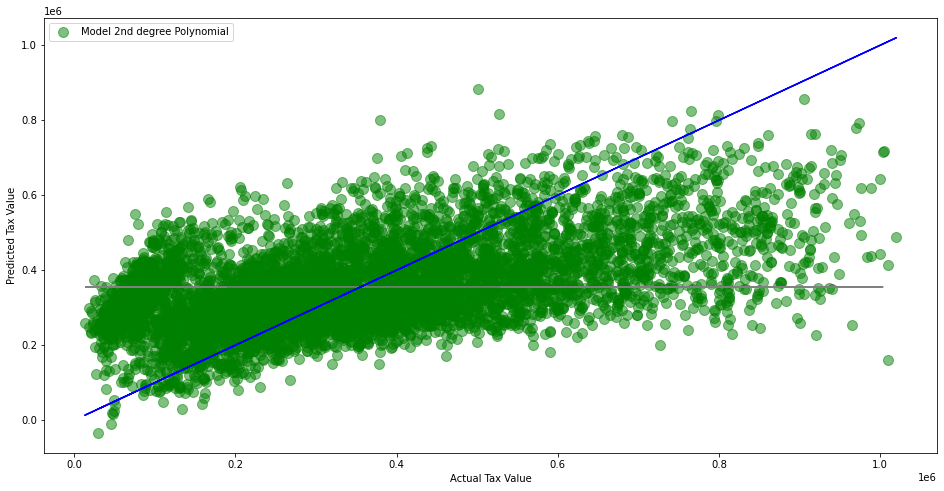

In [49]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=1, color="gray", label='_nolegend_')
plt.plot(y_test.tax_value, y_test.tax_value, alpha=1, color="blue", label='_nolegend_')

plt.scatter(y_test.tax_value, y_test.tax_value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

In [50]:
def rfe(X,y,k):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=k)
    rfe.fit(X_train_scaled, y_train)
    X_train.columns[rfe.get_support()]
    return pd.Series(rfe.ranking_, index=X_train.columns).sort_values()


In [51]:
X = df.drop(columns='tax_value')
y = df.tax_value

In [52]:
rfe(X,y,1)

area                      1
latitude                  2
longitude                 3
year_built                4
bedrooms                  5
fips                      6
garagecarcnt              7
transactiondate_week      8
transactiondate_month     9
transactiondate_day      10
bathrooms                11
lotsizesquarefeet        12
dtype: int64

In [53]:
# Running the model with more selective features

#train/validate/test split

train_validate, test = train_test_split(df, test_size=.2, random_state=321)
train, validate = train_test_split(train_validate, test_size=.3, random_state=321)


# drop target column and leaving more selective columns
X_train = train.drop(columns = ['tax_value','bedrooms','transactiondate_week','transactiondate_month',\
                                'transactiondate_day','bathrooms','lotsizesquarefeet'])
y_train = train.tax_value

X_validate = validate.drop(columns = ['tax_value','bedrooms','transactiondate_week','transactiondate_month',\
                                'transactiondate_day','bathrooms','lotsizesquarefeet'])
y_validate = validate.tax_value

X_test = test.drop(columns = ['tax_value','bedrooms','transactiondate_week','transactiondate_month',\
                                'transactiondate_day','bathrooms','lotsizesquarefeet'])
y_test = test.tax_value


# scaling my X data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)


In [54]:
# We need y_train, y_validate and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 2. compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  211368.06 
Validate/Out-of-Sample:  211956.06


In [55]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [56]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  177330.0639697042 
Validation/Out-of-Sample:  179052.83517776735
